In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Introduction to AI and OpenVino

## Session 02 - Probabilistic Approach for Classification

<img src='../../prasami_images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###------------------
### Import statements
###------------------

import sys
import os
from time import time
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from scipy.stats import norm
from scipy.integrate import simpson

In [3]:
# Some Basic Parameters for housekeeping

# set location of input files:
inpDir = os.path.join('..', '..', 'input')

# set location of inputs for this module
moduleDir = 'machine_learning'

# set location of output files
outDir = os.path.join('..', 'output')

# define and set random state 
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

NOISE = 0.1
N_SAMPLES = 1000

# parameters for Matplotlib
params = {'legend.fontsize': 'small',
          'figure.figsize': (15, 7),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large',
          'savefig.dpi': 75,
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 1,
          'legend.numpoints' : 1
         }

CMAP = plt.cm.rainbow
plt.rcParams.update(params);
plt.set_cmap(CMAP);

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

TEST_SIZE = 0.25

<Figure size 1500x700 with 0 Axes>


## Bayesian statistics

Bayes' Theorem, also known as Bayes' Rule, allows us to 'invert' conditional probabilities. As a reminder, conditional probabilities represent the probability of an event given some other event has occurred, which is represented with the following formula: 

P(X|Y) = $\frac{P(Y|X)P(Y)}{P(X)}$

The Naive Bayes classifier is a supervised machine learning algorithm, which is commonly applied in use cases involving recommendation systems, text classification, and sentiment analysis. Since it performs well with data sets with high dimensionality, it is a favored classifier for text classification in particular.

Naive Bayes (NB) is also a generative learning algorithm, which means that it models the distribution of data points for a given class or category. This probabilistic classifier is based off of Bayes' Theorem, meaning that this Bayesian classifier uses conditional probabilities and prior probabilities to calculate the posterior probabilities.

Naive Bayes classifiers work differently in that they operate under a couple of key assumptions, earning it the title of naive. It assumes that predictors in a Naive Bayes model are conditionally independent, or unrelated to any of the other feature in the model. It also assumes that all features contribute equally to the outcome.

While these assumptions are often violated in real-world scenarios (for example, a subsequent word in an e-mail is dependent upon the word that precedes it), it simplifies a classification problem by making it more computationally tractable. That is, only a single probability will now be required for each variable, which, in turn, makes the model computation easier. Despite this unrealistic independence assumption, the classification algorithm performs well, particularly with small sample sizes.

In this tutorial, we’ll use scikit-learn to walk through different types of Naive Bayes algorithms, focusing primarily on a popular text classification task (spam filtering) using Multinomial Naive Bayes.

## DataSet
<div><img src = '../../images/iris.png' width='400 px' align ='left'></div>

<div><img src = '../../images/iris_petal_sepal.png' width='200 px',  align ='left'></div>


### DataSet
1. Number of Instances: 150 (50 in each of three classes)
2. Number of Attributes: 4 numeric, predictive attributes and the class
3. Attribute Information:

   a. sepal length in cm
   
   b. sepal width in cm
   
   c. petal length in cm
   
   d. petal width in cm
   
   e. class:
      - Iris Setosa
      - Iris Versicolour
      - Iris Virginica
      
      
4. Missing Attribute Values: None
5. Class Distribution: 33.3% for each of 3 classes.


## Loading from CSV

>iris_df = pd.read_csv(iris_file, sep=',', skiprows=1, header=None, names = iris_features)

In [4]:
# CSV file name
iris_file = os.path.join(inpDir, moduleDir, 'iris.csv')

# Define feature names
iris_features = ['sepal length',
                 'sepal width',
                 'petal length',
                 'petal width',
                 'target']
# Read the CSV file
iris_df = pd.read_csv(iris_file, sep=',', skiprows=1, 
                      header=None, names = iris_features)

In [5]:
iris_df.head()

,sepal length,sepal width,petal length,petal width,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


## EDA

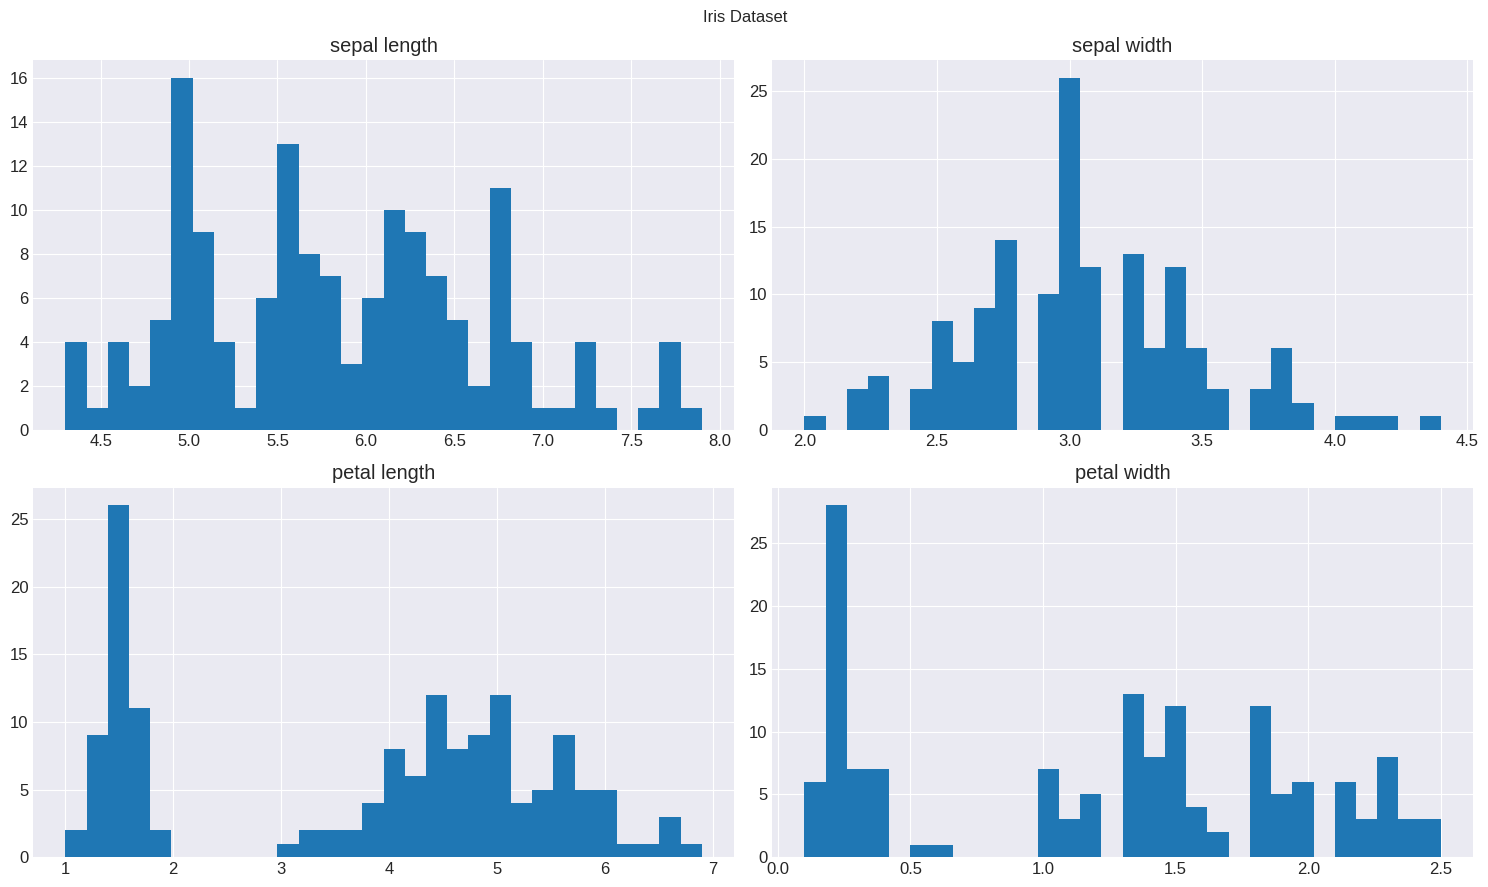

In [6]:
# Plot the features
fig = plt.figure( figsize = (15 , 9) )

fig.suptitle('Iris Dataset')

for count, col in enumerate(iris_df.columns[:-1]):
    
        # Add the first set of axes (subplot 1)
        ax = fig.add_subplot(2, 2, count+1)  # 2 row, 2 columns
                
        plt.subplots_adjust(wspace=0.1, hspace=0.1)
        
        n, bins, patches = ax.hist( iris_df [col], 30)
        
        ax.set_title('{}'.format(iris_df.columns[count]))
        
        ax.axis('tight')

        #plt.legend(loc = 'best')

plt.tight_layout()

plt.show()

## Feature Extraction

Extract features and labels from the dataframe.

**Remember:** We can use only numerical values in the features and labels. Incidentally, Iris dataset contains numerical values only.

In [7]:
features = iris_df.drop('target',axis=1)
labels = iris_df['target']

## Gaussian Distribution
Plot Gaussian distribution of all features. 

In [8]:
## Function to calculate Mean, Standard Deviation

def fn_calc_mu_std(df):

    '''
    Args:
        df: dataframe
    '''

    mu= {} # dictionary to hold mean
    
    std_dev = {} # dictionary to hold sigma
    
    min_val = {} # min value of the col
    
    max_val = {}
    
    for col in df.columns:
        
        mu[col] = df[col].mean()
        
        std_dev[col] = df[col].std()
        
        min_val[col] = df[col].min()
        
        max_val[col] = df[col].max()

    return mu, std_dev, min_val, max_val

In [9]:
# Some helpers to format the plot

target_names = ['setosa','versicolor','virginica']

# this formatter will label the colorbar with the correct target names
formatter = plt.FuncFormatter(lambda i, *args: target_names[int(i)])

# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='aqua', alpha=0.5)

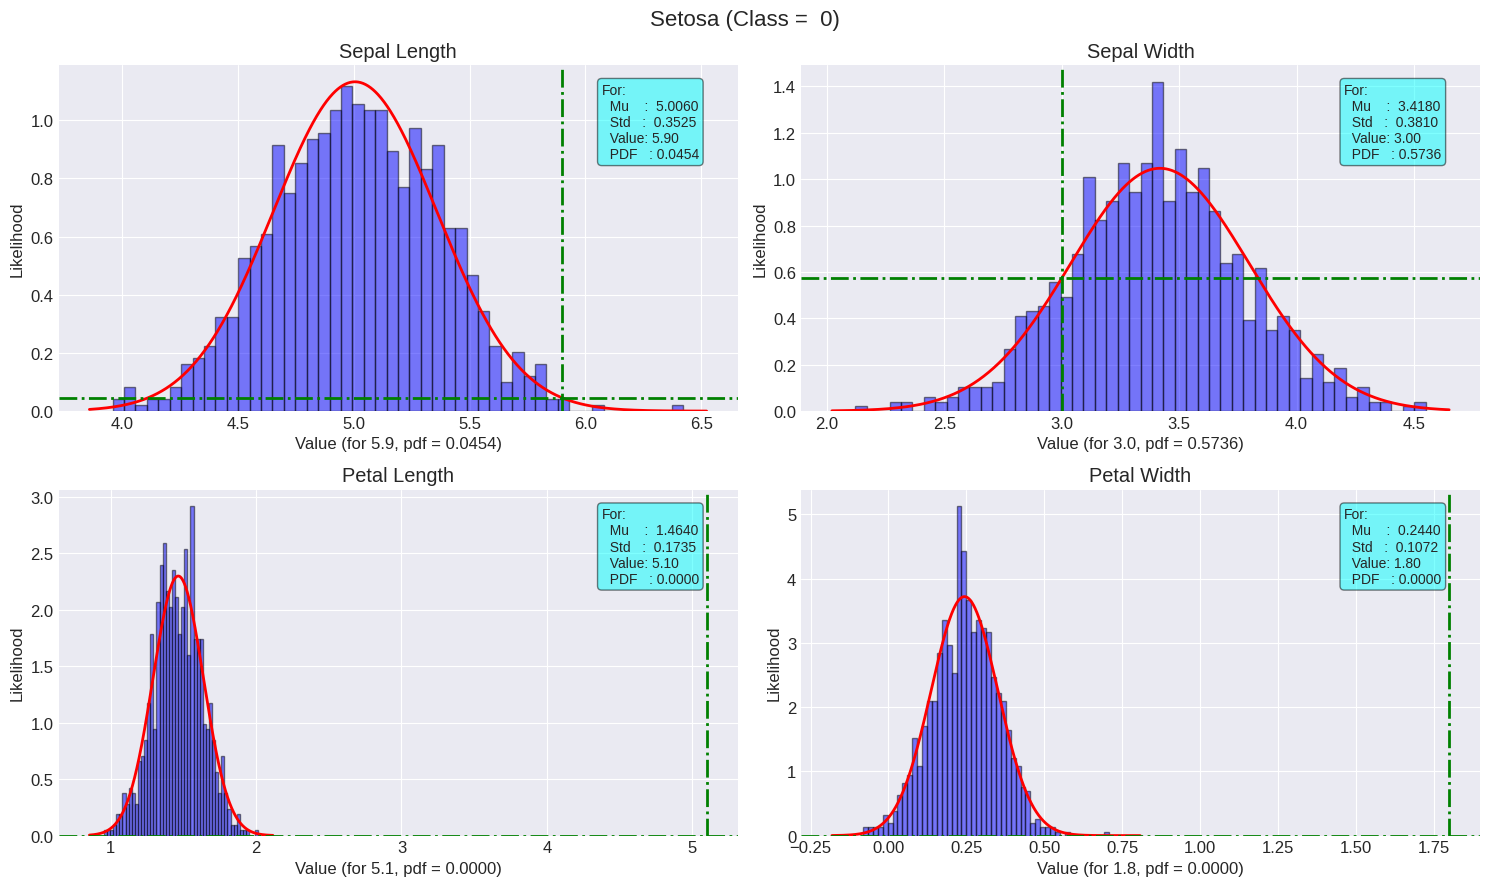

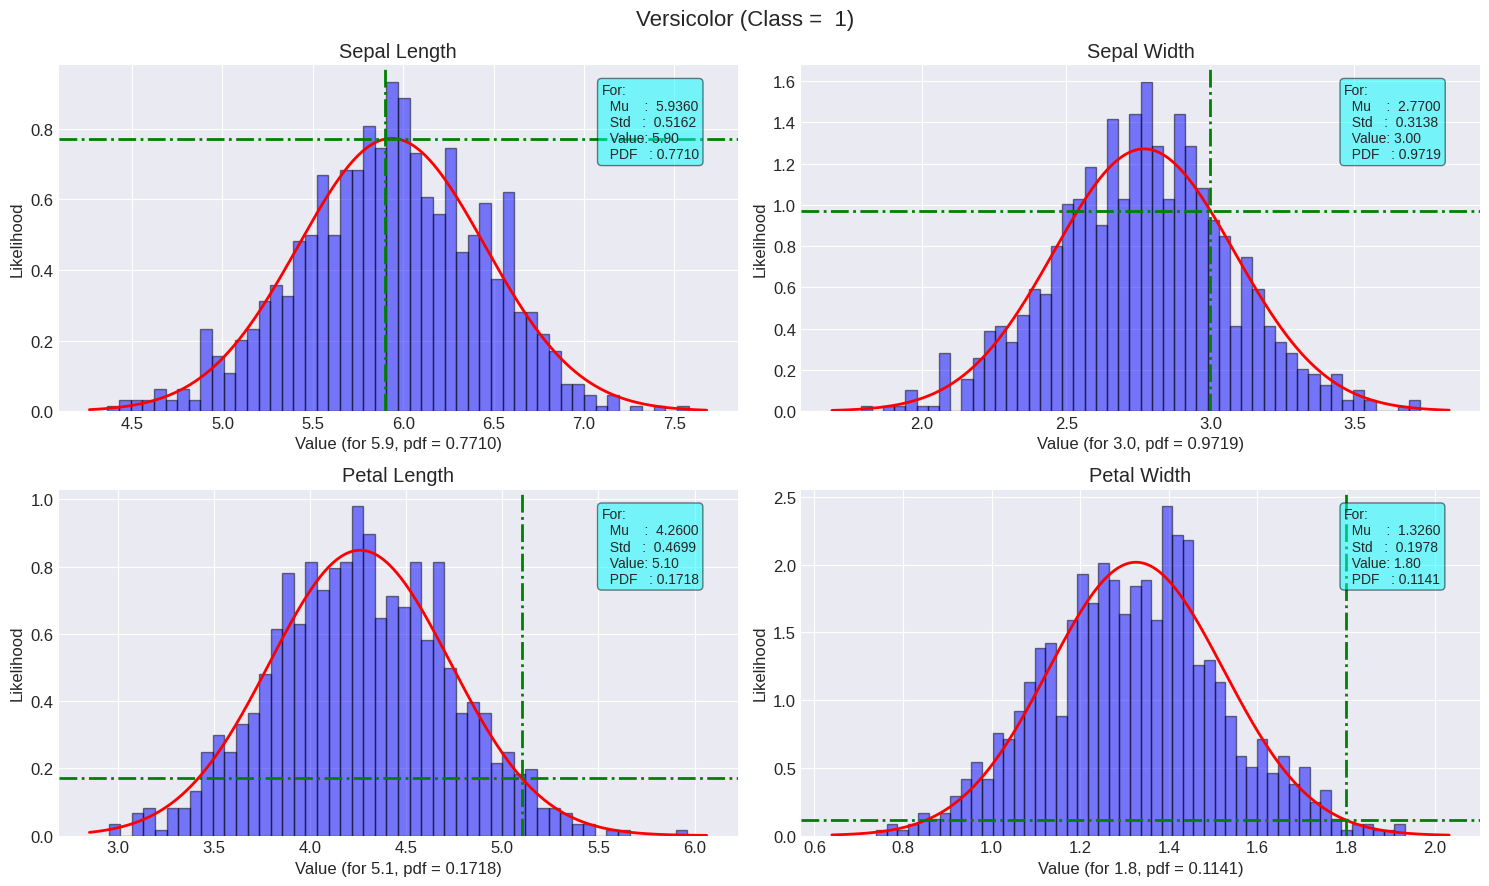

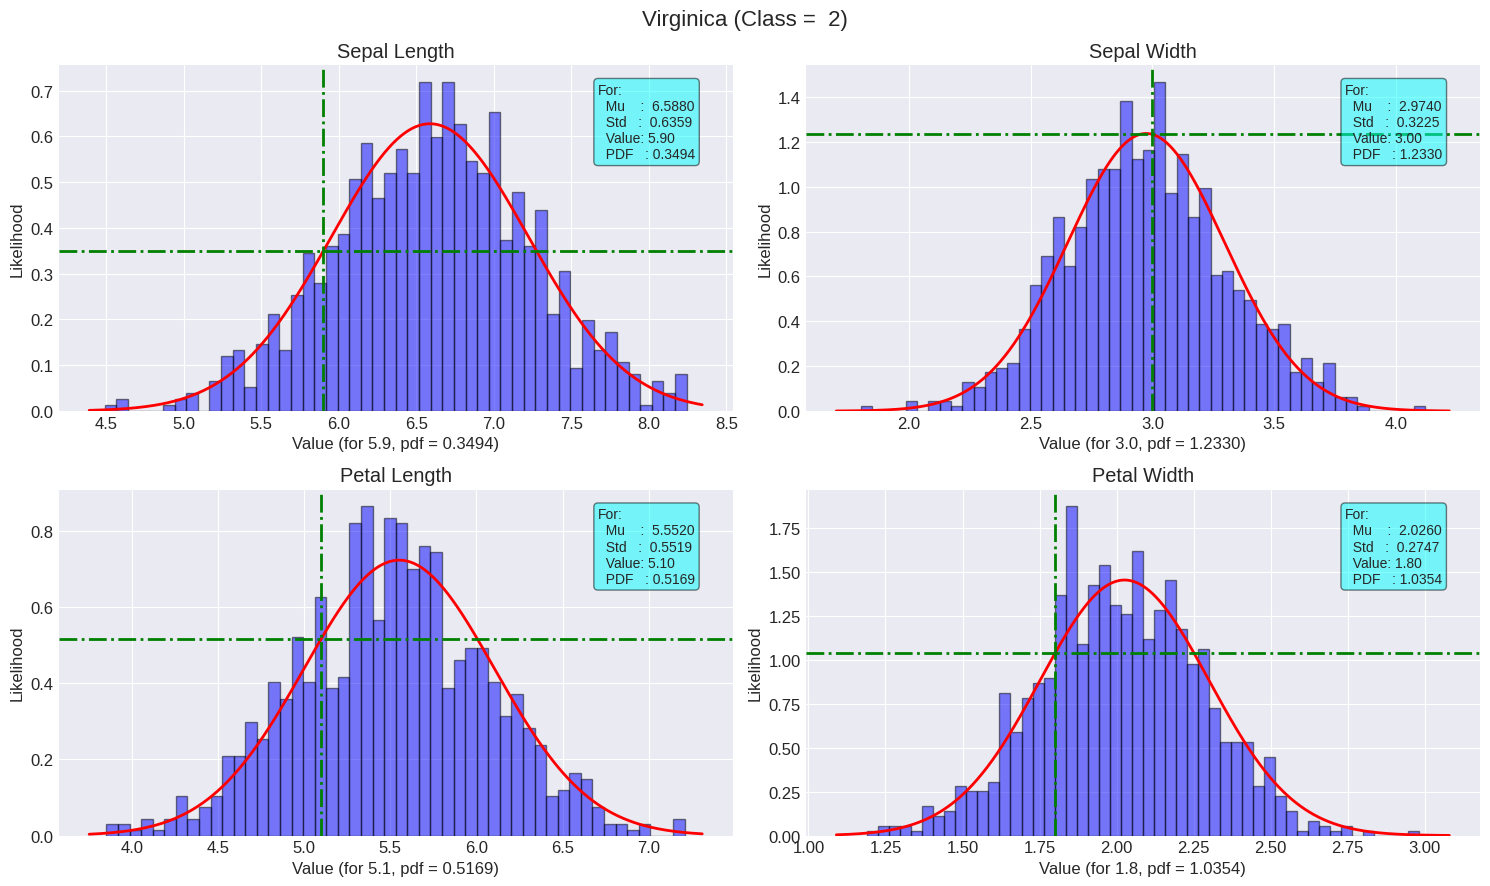

In [10]:
pdf_label = {}

for lbl in iris_df['target'].unique():

    label = target_names[lbl]
    
    tmp_df = iris_df[iris_df['target'] == lbl] # dataframe with one class

    tmp_df = tmp_df.drop('target', axis = 1)
    
    mu, std_dev, min_val, max_val = fn_calc_mu_std(tmp_df) # call fn using this tmp df

    fig, axes = plt.subplots(2,2, figsize = (15 , 9) )
    
    fig.suptitle(f'{label.title()} (Class = {lbl:2d})', fontsize =16)
    
    nSample = 1000

    pdf_col = {}
    
    for count, col in enumerate(tmp_df.columns):
    
        ax = axes.ravel()[count]
        
        meanVal = mu[col]
        stdDev = std_dev[col]
        minVal = min_val[col]
        maxVal = max_val[col]
        data = np.random.normal(meanVal, stdDev, nSample)
        
        ax.hist(data, bins=50, density=True, alpha=0.5, color='b', edgecolor='k')
        x = np.linspace(data.min()- 0.1, data.max() + 0.1, nSample)
        pdf = norm.pdf(x, meanVal, stdDev)
        ax.plot(x, pdf, 'r-', lw=2)
    
        val = features.iloc[-1][col]
        pdf_val = norm.pdf(val, meanVal, stdDev) # given the value what is the probability
        pdf_col[col] = pdf_val
        
        ax.axvline(x=val, color='g', linestyle='-.', linewidth=2)
        ax.axhline(y=pdf_val, color='g', linestyle='-.', linewidth=2)
        
        # little beautification
        fmtStr =  "For:\n  Mu    : {:7.4f}\n  Std   : {:7.4f}\n  Value:{:5.2f}\n  PDF   :{:7.4f}"
        txtstr =fmtStr.format(meanVal, stdDev, val, pdf_val) #text to plot
        # place a text box in upper left in axes coords
        
        ax.text(0.8, 0.95, txtstr, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=props)

        
        ax.set_title(col.title())
        ax.set_xlabel(f"Value (for {val}, pdf = {pdf_val:.4f})")
        ax.set_ylabel("Likelihood")
    pdf_label[ label] = pdf_col
    plt.tight_layout()
    plt.savefig(os.path.join(outDir,f'gaussian_iris_{label}.png'))
    plt.show()


In [11]:
# look at Probability distributions
pdf_label

{'setosa': {'sepal length': 0.04538959059205931,
  'sepal width': 0.5736143870495231,
  'petal length': 1.0133390358971727e-95,
  'petal width': 6.753703472451379e-46},
 'versicolor': {'sepal length': 0.7710101202357021,
  'sepal width': 0.9718584132539116,
  'petal length': 0.1717982477055382,
  'petal width': 0.11408115120771109},
 'virginica': {'sepal length': 0.34940711315643136,
  'sepal width': 1.2330295149586672,
  'petal length': 0.5168935071010351,
  'petal width': 1.03537671228938}}

In [12]:
# Iterate and calculate the probabilities
y_pred = []

for k,val_lbl in pdf_label.items():
    
    prob = 1
    
    for k_col, val_col in val_lbl.items():
        
        prob *= val_col
        
    y_pred.append(prob)
    
    print (f'For Label: {k:11s}; likelihood : {prob: 0.4f}')


y_pred = [v/sum(y_pred) for v in y_pred] # Normalize sum to 1

print (f'\nProbabilities : {y_pred}')

For Label: setosa     ; likelihood :  0.0000
For Label: versicolor ; likelihood :  0.0147
For Label: virginica  ; likelihood :  0.2306

Probabilities : [7.265276020022553e-142, 0.05987903023763667, 0.9401209697623633]


## Probability vs. Likelihood

Probability: probability of value in a range given a distribution i.e. area under the curve. Probability are the areas under fixed distribution i.e. 
>p(data| distribution)

Likelihood: for a distribution how likely a value is. Y-axis values for fixed data points with a distributions i.e. 
>L(distribution | data)

## Classifier

<img src='../../images/ML_steps.png'>

In [13]:
#Make predictions using Gaussian Naive Bayes

from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

# instantiate
clf = GaussianNB()

# fit the classifier
clf.fit(features, labels)

# make predictions
y_pred = clf.predict(features)

In [14]:
# Let's use first two columns of the data and plot the data to visualize the results
xplot = iris_df.keys()[0]

yplot = iris_df.keys()[1]


# also locate instances which are incorrectly predicted.
x_err = iris_df[xplot][(labels != y_pred)]
y_err = iris_df[yplot][(labels != y_pred)]

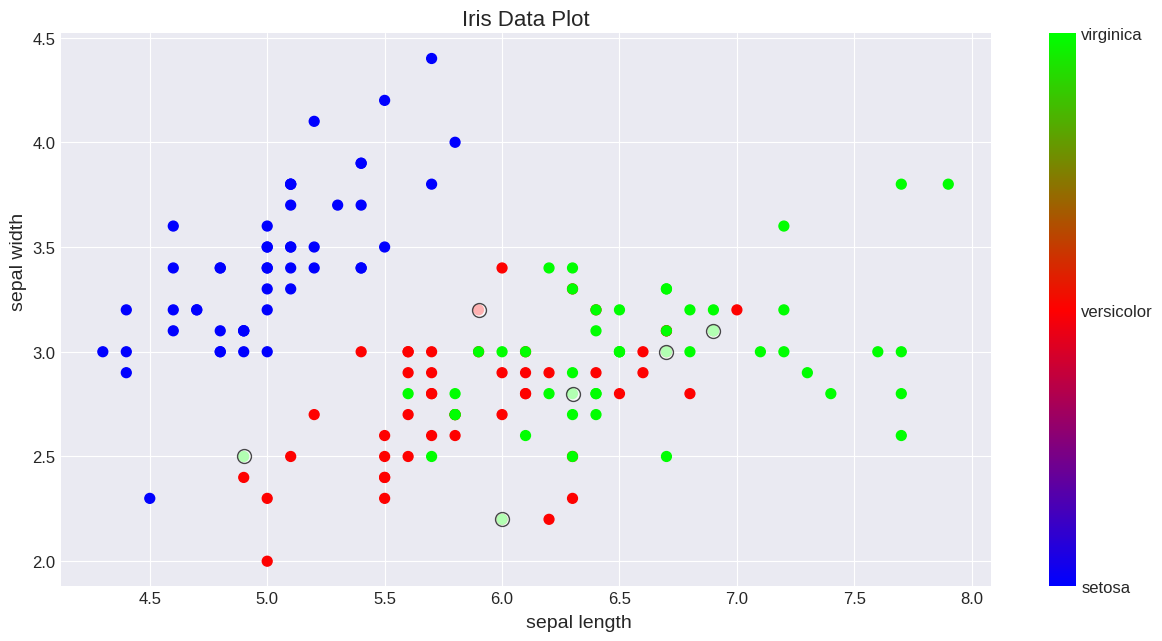

In [15]:
# Plot the data points

# Create a figure of given size
fig = plt.figure()

# Add a subplot
ax = fig.add_subplot(111)

# Set title
title = 'Iris Data Plot'

plt.scatter( iris_df[xplot], iris_df[yplot], s = 50, 
            c = iris_df['target'], 
            cmap=plt.cm.brg) # , 

plt.colorbar(ticks=[0, 1, 2], format=formatter)

plt.scatter(x_err, y_err, color = "w", label="mismatch", 
            s = 100, alpha = 0.7, edgecolor = 'black')

# Grid lines inside plot can be set as True or False
ax.grid(True)

# Plot frame can be set as true or false
ax.set_frame_on(True)

 
# Customize title, set position, allow space on top of plot for title
ax.set_title(title, fontsize=16, ha='center')

plt.subplots_adjust(top=0.9)

ax.title.set_position((0.5,1))

# Set x axis label
ax.xaxis.set_label_position('bottom')

ax.set_xlabel(xplot, fontsize=14,  ha='left') 

ax.xaxis.set_label_coords(0.5, -0.05)

# Set y axis label
ax.set_ylabel(yplot, fontsize=14,  ha='left') 

plt.show()

In [16]:
iris_correct = iris_df[(labels == y_pred)]


accuracy = (iris_correct.shape[0]/iris_df.shape[0])

print ("We have predicted {:d} points correctly out of {:d} points".format (
        iris_correct.shape[0],iris_df.shape[0] ))

print ("Hence, the accuracy is {:5.3f}".format(accuracy))

We have predicted 144 points correctly out of 150 points
Hence, the accuracy is 0.960


We can also use `sklearn` built-in function to calculate accuracy.

In [17]:
accuracy = accuracy_score(labels, y_pred)

print ("The accuracy is {:5.3f}".format(accuracy))

The accuracy is 0.960


## Multinomial Naive Bayes model

Multinomial Naive Bayes algorithm is a probabilistic learning method that is mostly used in Natural Language Processing (NLP). The algorithm is based on the Bayes theorem and predicts the tag of a text such as a piece of email or newspaper article. It calculates the probability of each tag for a given sample and then gives the tag with the highest probability as output. 

Also Read [here](https://developer.ibm.com/tutorials/awb-classifying-data-multinomial-naive-bayes-algorithm/) for more details on Multinomial Naive Bayes Model 

In [18]:
# instantiate
clf = MultinomialNB(alpha = 0.1)

# fit the classifier
clf.fit(features, labels)

# make predictions
y_pred = clf.predict(features)

In [19]:
accuracy = accuracy_score(labels, y_pred)

print ("The accuracy is {:5.3f}".format(accuracy))

The accuracy is 0.953


## Bernoulli Naive Bayes

Similarly, to use Bernoulli Naive Bayes, the data for each of the feature values is drawn from a Bernoulli distribution.

In [20]:
X, y = datasets.make_moons(n_samples=N_SAMPLES, 
                           shuffle=True, 
                           noise=NOISE, 
                           random_state=RANDOM_STATE)
X[:5], y[:5]

(array([[ 0.79254123,  0.81852609],
        [-0.86341583,  0.77353281],
        [ 1.94098477,  0.40538635],
        [-0.96149236,  0.06064943],
        [-0.98373033,  0.05715389]]),
 array([0, 0, 1, 0, 0]))

In [21]:
# what labels are present?
np.unique(y)

array([0, 1])

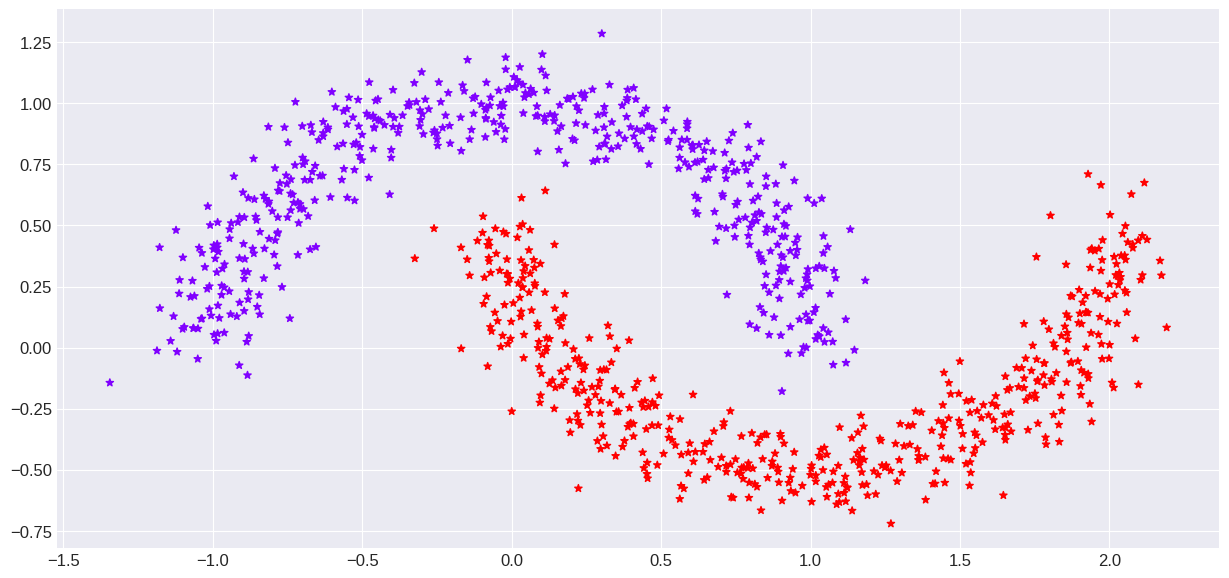

In [22]:
#### In case you want to plot X Array directly
plt.scatter(X[:,0], X[:,1], s=30, c=y, marker = '*', cmap=CMAP)

In [23]:
# instantiate
clf = BernoulliNB()

# fit the classifier
clf.fit(X, y)

# make predictions
y_pred = clf.predict(X)

In [24]:
accuracy = accuracy_score(y, y_pred)

print ("The accuracy is {:5.3f}".format(accuracy))

The accuracy is 0.825
